In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn import svm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import neighbors
from decimal import Decimal as D
import pylab
import matplotlib.gridspec as gridspec
from scipy.signal import butter, lfilter, freqz
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

gesture = []
for i in range (1,8):
    filename = '../GesturePredict/data/g' + str(i) + '_1.csv'
    data = pd.read_csv (filename, sep = ';')
    data.columns = ['time', '1','21', '2','31', '3','41', '4','51', '5','61', '6','71', '7','81', '8']
    data = data[['time', '1','2','3','4','5','6','7','8']]
    for i in range (1,9):
        colName = str(i)
        data [colName] = data [colName].str.replace(',', '.')
        data [colName] = pd.to_numeric(data [colName], errors='coerce')
        #data[colName] = StandardScaler().fit_transform(data[colName][:,np.newaxis])
    gesture.append(data)

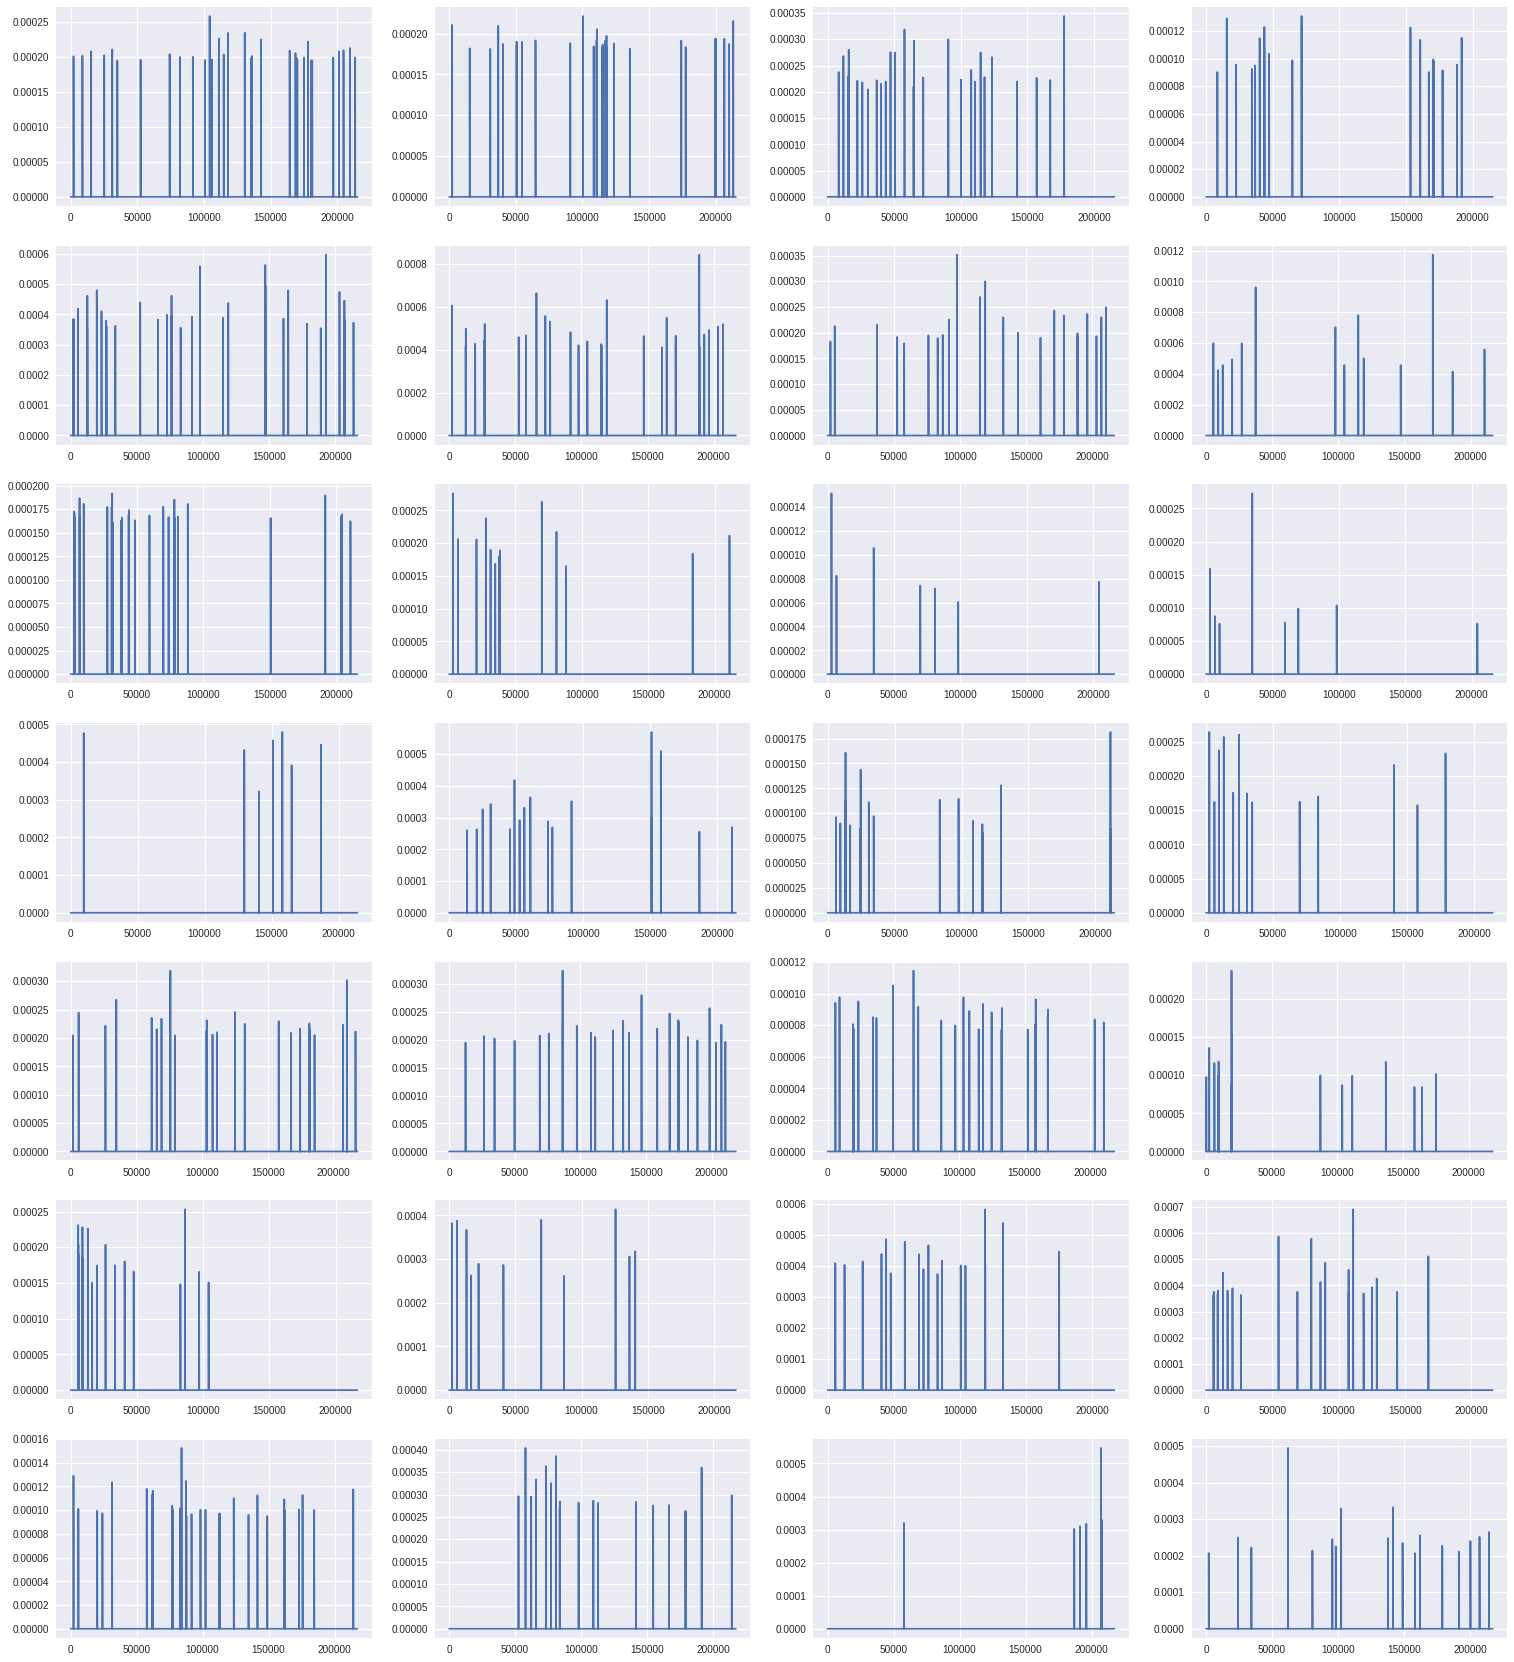

In [21]:
#В тупую беру максимумы - не надо так!
rows = 7
cols = 4

fig = plt.figure(figsize = (26,30))
gs1 = gridspec.GridSpec(rows, cols)

plots = []
for i in range (0,rows):
    for j in range (1,cols+1):
        data = gesture[i][str(j)].copy(deep = True)
        plots.append(fig.add_subplot(gs1[cols*i + j - 1]))

        
        border = sorted(gesture[i][str(j)])[-50]
        data = data.values
        data[data < border] = 0
        
        plt.plot( np.arange(0, len(data)), data )

plt.show()

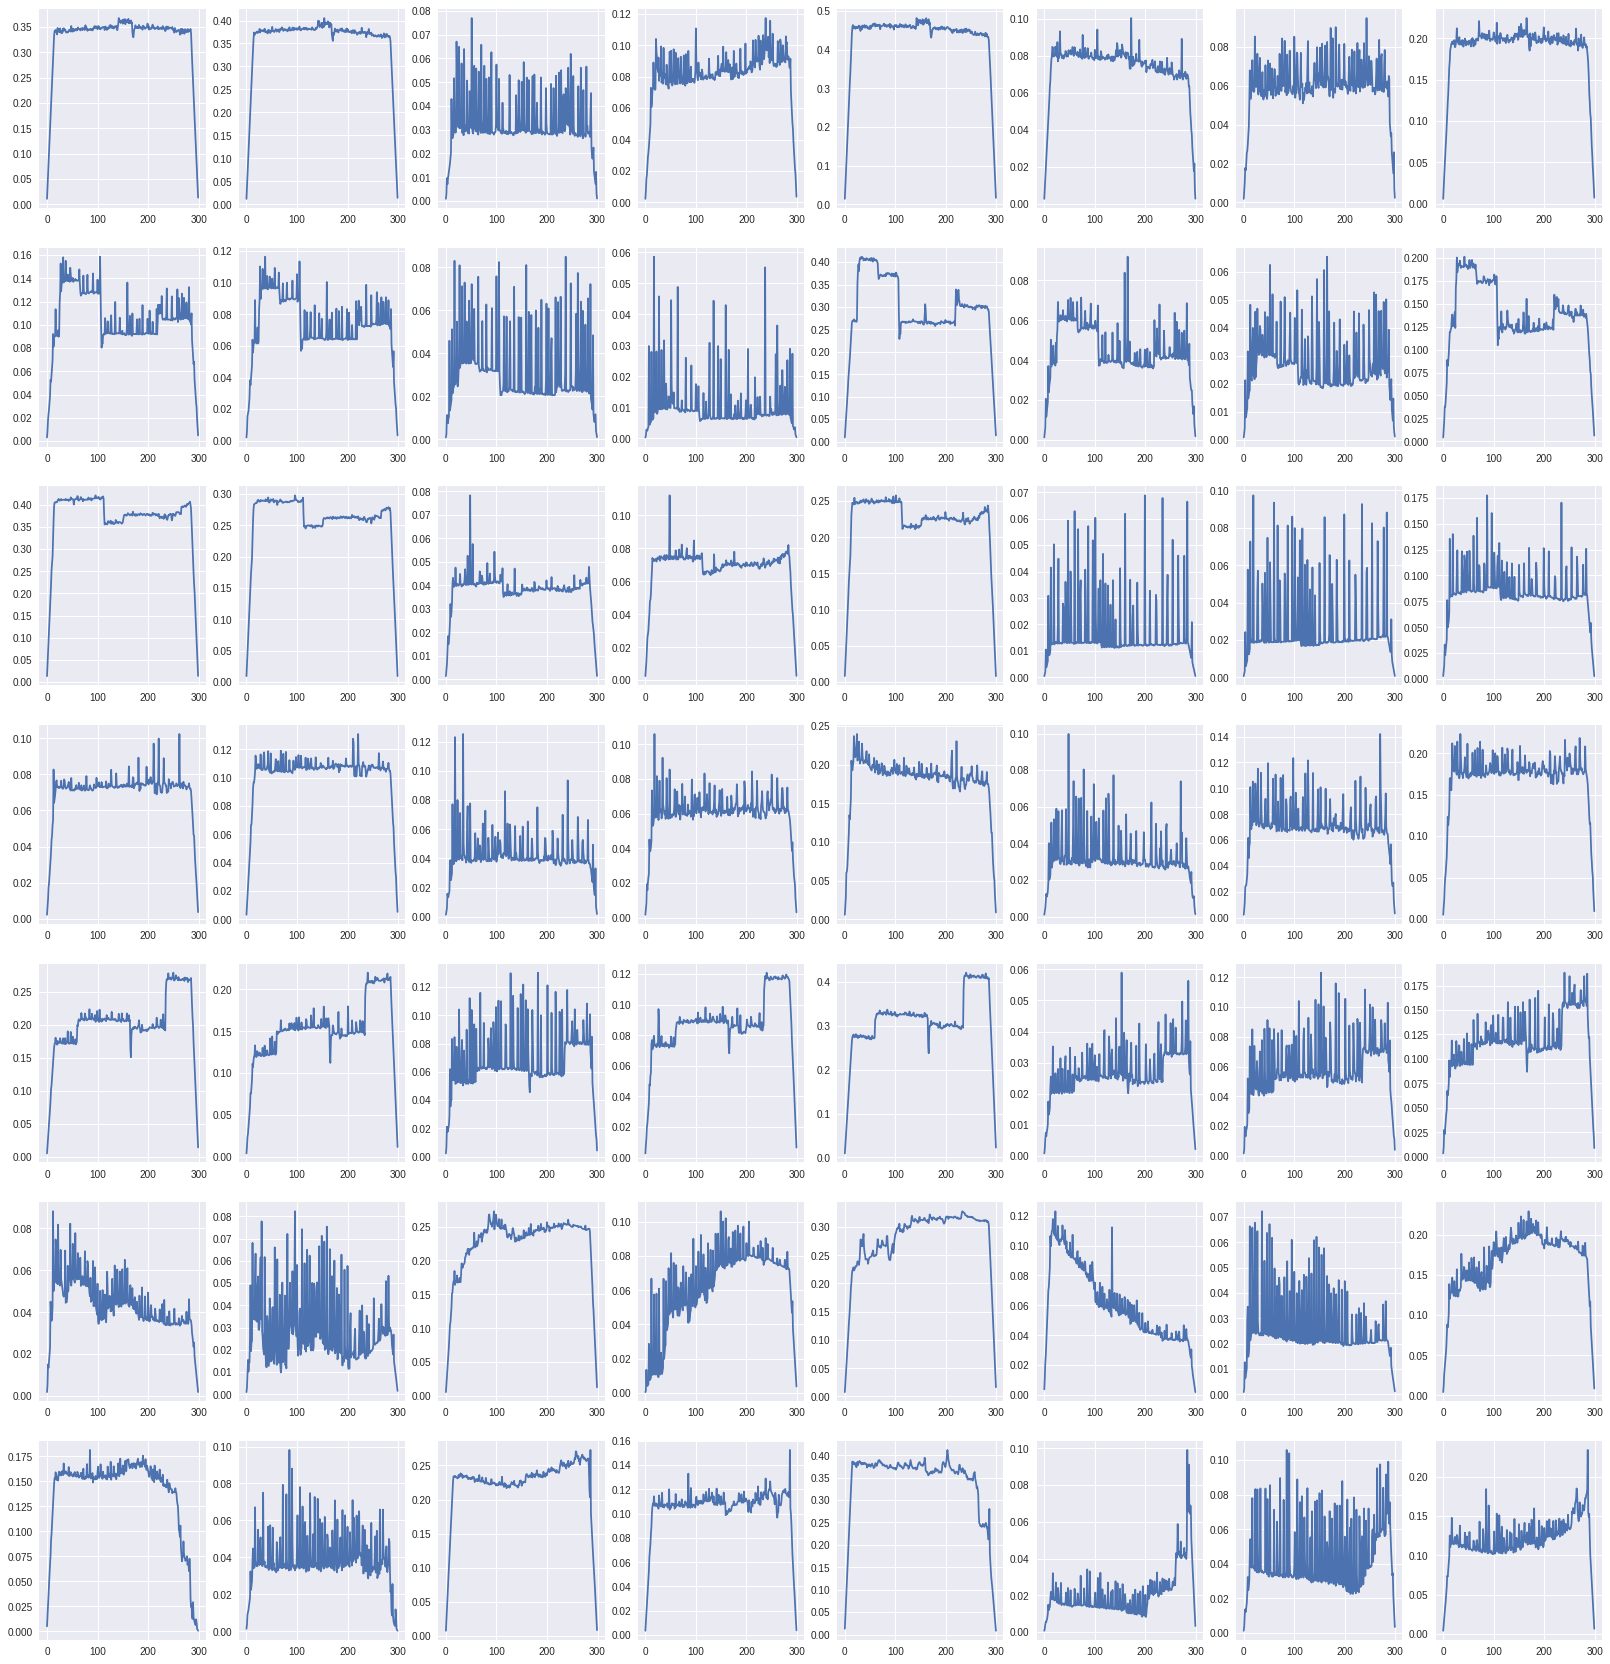

In [161]:
#Берем мощность по корзинам
def removeNoise (data, time):
    nSamples = len(data)
    sin = thinkdsp.SinSignal(freq=1360, amp=5, offset=0)
    wave = sin.make_wave(duration=1, start=0, framerate=nSamples*100)
    wave.ys = data
    wave.ts = time
    wave.normalize()
    wave.apodize()
    spectrum = wave.make_spectrum()
    spectrum.band_stop(0, 1000)
    spectrum.band_stop(10000, 12000)
    spectrum.band_stop(31800, 33000)
    spectrum.band_stop(53000, 54000)
    spectrum.band_stop(75000, 76000)
    spectrum.band_stop(96000, 97500)
    filtered = spectrum.make_wave()
    waveList.append(filtered)
    return filtered.ys

def plotSpectra (data, time):
    nSamples = len(data)
    sin = thinkdsp.SinSignal(freq=1360, amp=5, offset=0)
    wave = sin.make_wave(duration=1, start=0, framerate=nSamples)
    wave.ys = data
    wave.ts = time
    wave.normalize()
    spectrum = wave.make_spectrum()
    spectrum.plot()

def plotEnergy (data, bins):
    segment = int(len(data)/bins)
    powers = []
    for k in range (0, bins):
        #powers.append(data[segment*k : segment*(k+1)].abs().sum() / segment)
        powers.append(sum(abs(data[segment*k : segment*(k+1)])) / segment)
    plt.plot( np.arange(0, len(powers)), powers )
    return powers

rows, cols = 7,8
fig = plt.figure(figsize = (28,30))
gs1 = gridspec.GridSpec(rows, cols)

waveList = []
bins = 300
X = np.zeros(shape=(rows*cols,bins))
y = np.zeros(shape=(rows*cols))


plots = []
for i in range (0,rows):
    for j in range (1,cols+1):
        data = gesture[i][str(j)].copy(deep = True)
        data = removeNoise(data, gesture[i]['time'])
        plots.append(fig.add_subplot(gs1[cols*i + j - 1]))
        powers = plotEnergy(data, bins)
        
        X[i*cols + j - 1] = powers
        y[i*cols + j - 1] = i
        
        #One pick everywhere
        #plotSpectra(data, gesture[i]['time'])
plt.show()

In [73]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

#“l1”, “l2”, “manhattan”, “cosine”, or ‘precomputed’

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
model = AgglomerativeClustering(n_clusters=7, linkage="ward", affinity = 'l1') 
model.fit(X_train, y_train)

answer = model.fit_predict(X_test)
correct = 0
for i in range (0, len(y_test)):
    if answer[i] == y_test[i]:
        correct+=1

accuracy = correct / len(y_test)
print(accuracy)

ValueError: l1 was provided as affinity. Ward can only work with euclidean distances.

In [202]:
#Поищем хорошие параметры для классификатора
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=44344)
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100,500, 1000,5000,10000,20000]},
                    {'kernel': ['poly'], 'gamma': [0.01,0.1,1,10]}]

clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % 'precision')
clf.fit(X_train,y_train)

print(clf.best_params_)

correct = 0
for i in range (0, len(y_test)):
    if clf.predict(X_test[i]) == y_test[i]:
        print(clf.predict(X_test[i]))
        correct+=1

accuracy = correct / len(y_test)
print(accuracy)
print(y_train)

{'C': 100, 'kernel': 'linear'}
[ 1.]
[ 0.]
[ 4.]
[ 3.]
[ 3.]
[ 6.]
[ 4.]
[ 5.]
[ 4.]
[ 2.]
[ 1.]
[ 0.]
[ 1.]
0.38235294117647056
[ 0.  6.  0.  1.  3.  1.  6.  0.  1.  6.  5.  5.  3.  5.  5.  6.  4.  1.
  6.  6.  0.  2.]


In [191]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=4631)
X_train, y_train = make_classification(n_samples=len(X_train), n_features=300, n_clusters_per_class=1, n_informative=15)
clf = RandomForestClassifier(max_depth=20, random_state=1)
clf.fit(X_train, y_train)

correct = 0
for i in range (0, len(y_test)):
    if clf.predict(X_test[i]) == y_test[i]:
        correct+=1

accuracy = correct / len(y_test)
print(accuracy)
print(y_train)

0.17391304347826086
[0 0 0 1 1 1 1 1 0 0 1 0 1 0 1 0 0 1 0 1 0 1 1 0 1 1 0 0 0 1 0 1 0]


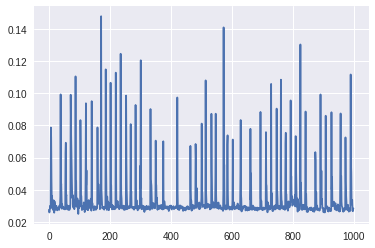

In [217]:
def plotGuest(i,j):
    data = gesture[i][str(j)].copy(deep = True)
    bins = 1000    
    segment = int(len(data)/bins)
    powers = []
    for k in range (0, bins):
        powers.append(data[segment*k : segment*(k+1)].abs().sum() / segment)

    plt.plot( np.arange(0, len(powers)), powers )

In [2]:
#Try using thinkDSP
from __future__ import print_function, division
import thinkdsp
import thinkplot
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Audio

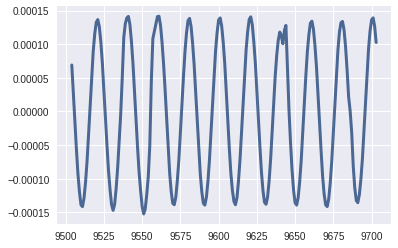

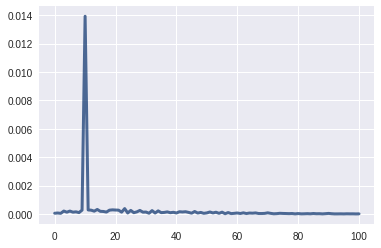

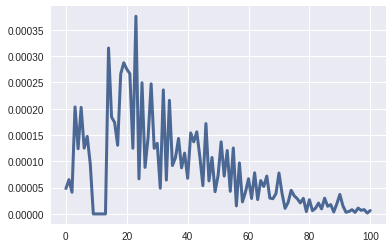

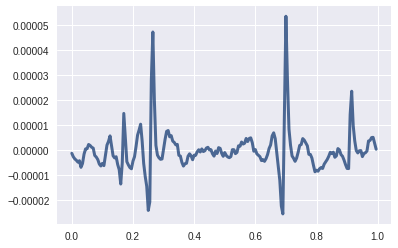

In [33]:
#4 graphics to see difference before/after cutting
x0 = 5200
x1 = 5400
time = gesture[0]['time'][x0:x1]
data = gesture[0]['1'][x0:x1]

nSamples = len(data)
sin = thinkdsp.SinSignal(freq=1360, amp=5, offset=0)

wave = sin.make_wave(duration=1, start=0, framerate=nSamples)
wave.ys = data
wave.ts = time
plt.figure()
wave.plot()

plt.figure()
spectrum = wave.make_spectrum()
spectrum.plot()

plt.figure()
spectrum.band_stop(8, 14)
spectrum.band_stop(10000, 12000)
spectrum.band_stop(31800, 33000)
spectrum.band_stop(53000, 54000)
spectrum.band_stop(75000, 76000)
spectrum.band_stop(96000, 97500)
spectrum.plot()

#Build the wave back!
filtered = spectrum.make_wave()
plt.figure()
filtered.plot()

In [44]:
#Finding peaks
for sample in spectrum.peaks():
    if sample[1] > 50000 and sample[1] <60000:
        print(sample)

(0.0094499958831195715, 53800.0)
(0.0090730199982527703, 53801.0)
(0.0083618060787893893, 53797.0)
(0.0068854118824737435, 53790.0)
(0.0066971717566888939, 53792.0)
(0.0064557687891012728, 53793.0)
(0.0064227036729692421, 53803.0)
(0.0064092590872044559, 53798.0)
(0.0060237805201694555, 50127.0)
(0.0058590144159429008, 53806.0)
(0.0056008759763983441, 52358.0)
(0.0051925666623025366, 54287.0)
(0.0051831123225090283, 50529.0)
(0.0051327266980452542, 52512.0)
(0.0048690613475745612, 58765.0)
(0.0048141777337413032, 52959.0)
(0.0046996419676530567, 53781.0)
(0.0046866291210177291, 54906.0)
(0.0046195032941306639, 50144.0)
(0.0045651462378859973, 53286.0)
(0.0045374496958487083, 54932.0)
(0.0044855530148317302, 54132.0)
(0.0044723301982352685, 51753.0)
(0.0044509810709920713, 53043.0)
(0.0044151069915558429, 53771.0)
(0.0044098339124188646, 52813.0)
(0.0043837923753886334, 58230.0)
(0.0043748064146242136, 58736.0)
(0.0043384702460822168, 50377.0)
(0.0043260543618867274, 53795.0)
(0.0043129

(0.0024519742609954362, 57824.0)
(0.0024508165416025633, 51968.0)
(0.0024505166644887147, 52484.0)
(0.0024499015599714629, 51540.0)
(0.0024493906034283807, 51513.0)
(0.002449032769695398, 54854.0)
(0.0024488320329848824, 53194.0)
(0.0024486791748237267, 55400.0)
(0.0024469721993905804, 52688.0)
(0.0024467436791450335, 54971.0)
(0.0024466924392461927, 53386.0)
(0.0024462486267163375, 56390.0)
(0.0024462432953132377, 53902.0)
(0.0024452080386828932, 59822.0)
(0.0024450958622505769, 58075.0)
(0.0024445383026443098, 51969.0)
(0.0024443953288603966, 54355.0)
(0.0024441364937237385, 50515.0)
(0.0024440975753613095, 52932.0)
(0.0024433036855374744, 58268.0)
(0.0024426235467489132, 52180.0)
(0.0024410561035130281, 50431.0)
(0.0024408471045300833, 52764.0)
(0.0024403882034682699, 57396.0)
(0.0024400248219744337, 51666.0)
(0.0024397520615814846, 53625.0)
(0.0024397202754228371, 52886.0)
(0.0024395997598462963, 52916.0)
(0.0024394599245850025, 52347.0)
(0.002439113582238135, 56398.0)
(0.002438792

(0.0020020814938035295, 54953.0)
(0.0020014345235899646, 51898.0)
(0.0020013519094007246, 53172.0)
(0.0020013122648957359, 57497.0)
(0.0020012130597172684, 58390.0)
(0.0020008914362059831, 59650.0)
(0.0020006500083683894, 54939.0)
(0.0019995375720318381, 55513.0)
(0.0019994880679078857, 52321.0)
(0.0019990742434855659, 50820.0)
(0.0019983649999660838, 55971.0)
(0.0019978381055432773, 53275.0)
(0.0019971416776724993, 56885.0)
(0.001996983103321812, 55594.0)
(0.0019969114718561437, 50300.0)
(0.0019965941711880849, 52068.0)
(0.0019965794674237322, 50451.0)
(0.0019959194778860563, 53916.0)
(0.0019956212443132293, 50123.0)
(0.0019954011919584968, 56806.0)
(0.0019948484204634536, 54413.0)
(0.0019947298845908552, 55432.0)
(0.0019945368670943168, 50867.0)
(0.0019942781464710878, 56112.0)
(0.0019940694304360616, 56945.0)
(0.0019937224703590051, 56947.0)
(0.0019929823524954832, 52778.0)
(0.0019928395591570615, 59220.0)
(0.0019928018249055776, 55505.0)
(0.0019926321663791629, 54242.0)
(0.00199258

(0.0017047759969996217, 53523.0)
(0.0017040520206396898, 58527.0)
(0.0017038751509093509, 53039.0)
(0.0017034413069634347, 59242.0)
(0.0017030318216599107, 54861.0)
(0.0017028781935893981, 57531.0)
(0.0017028654177230829, 59991.0)
(0.0017028546759866843, 51117.0)
(0.0017026526023068017, 55317.0)
(0.0017025744221874748, 54127.0)
(0.0017024937726342866, 54672.0)
(0.0017023229603689986, 51721.0)
(0.0017021282792492082, 56969.0)
(0.0017011926418872409, 58115.0)
(0.0017010440235843386, 53845.0)
(0.0017009076632837959, 56396.0)
(0.001700697934805162, 54421.0)
(0.0017006750748748399, 59189.0)
(0.0017006306170213603, 50343.0)
(0.0017006059747517945, 55769.0)
(0.0017005068600040435, 51381.0)
(0.0017004030731105485, 54138.0)
(0.0017001686480999196, 53345.0)
(0.0017001394858802629, 50380.0)
(0.0017001003257591659, 54448.0)
(0.0017000703091376993, 57131.0)
(0.0016996859632850052, 50115.0)
(0.0016994473751111656, 55313.0)
(0.001699282123229085, 59682.0)
(0.0016992029860511523, 50883.0)
(0.001699099

(0.0012950852712137592, 59619.0)
(0.0012946722561412449, 50148.0)
(0.0012943550409960768, 50517.0)
(0.0012942839864767198, 50921.0)
(0.0012942145470647738, 50258.0)
(0.0012936899376137937, 59115.0)
(0.0012936857796359402, 52626.0)
(0.0012936663534142423, 53007.0)
(0.0012933447170783421, 56878.0)
(0.0012932395494213789, 57165.0)
(0.0012932033249933997, 57160.0)
(0.001292757523319127, 53251.0)
(0.0012925348543054644, 55145.0)
(0.0012925277473442385, 50897.0)
(0.0012920627141893891, 53839.0)
(0.0012920386371445673, 56743.0)
(0.0012920006283416666, 56671.0)
(0.0012918146553100279, 57222.0)
(0.0012916072341853583, 55933.0)
(0.0012911827358163745, 58915.0)
(0.0012911697657952696, 56234.0)
(0.0012911195952876298, 58931.0)
(0.0012907214364878245, 51477.0)
(0.0012905156343071885, 50614.0)
(0.0012900488769498071, 57207.0)
(0.0012898915745050939, 57690.0)
(0.0012896295665906065, 54737.0)
(0.0012893837692395679, 54350.0)
(0.001289293758292401, 57729.0)
(0.0012890042748183381, 54565.0)
(0.001288252

(0.0010041243753872876, 56731.0)
(0.0010038178751972256, 50507.0)
(0.001003706338338234, 51295.0)
(0.0010036852506950355, 59944.0)
(0.0010034236862375234, 57183.0)
(0.0010030009705843574, 51352.0)
(0.0010026222303800595, 57620.0)
(0.0010024183234699309, 54908.0)
(0.001002230833331459, 56012.0)
(0.0010021743540971997, 54480.0)
(0.0010019519373334034, 57380.0)
(0.0010016706936941322, 59185.0)
(0.001001385805996486, 58484.0)
(0.0010011410575561234, 59922.0)
(0.0010011142894510066, 55907.0)
(0.0010009805237958785, 52686.0)
(0.0010009034384664017, 56361.0)
(0.0010008567262391114, 50565.0)
(0.001000701256351633, 51176.0)
(0.0010006900713151177, 56193.0)
(0.00099968894191044123, 50386.0)
(0.00099926205898022489, 51025.0)
(0.00099922313262141064, 52584.0)
(0.00099917630352700459, 57201.0)
(0.00099908565691275058, 59171.0)
(0.00099785027355891336, 58717.0)
(0.00099780003909827851, 56652.0)
(0.00099763525773580684, 51245.0)
(0.00099756620941052199, 53826.0)
(0.00099755708932018389, 50357.0)
(0.0

(0.00061456323715353763, 57577.0)
(0.0006145396950230673, 56532.0)
(0.00061451488216663903, 53859.0)
(0.00061353099211577185, 50304.0)
(0.00061334670031495963, 51715.0)
(0.00061308231577674084, 57099.0)
(0.00061229071586382897, 50156.0)
(0.00061191082766811678, 55583.0)
(0.00061139333260267045, 50609.0)
(0.00061092976343878524, 54457.0)
(0.00061064761790229126, 55706.0)
(0.00061033635721416998, 57649.0)
(0.00061010440077590745, 53129.0)
(0.00060966009727104857, 59487.0)
(0.0006094760407080672, 59647.0)
(0.00060942191155005112, 57155.0)
(0.00060941338224041917, 51424.0)
(0.00060909195645855903, 55732.0)
(0.00060890182779397249, 53223.0)
(0.00060890154295266472, 54105.0)
(0.00060817145434538197, 53615.0)
(0.00060806417040299603, 56606.0)
(0.0006077913369910259, 54532.0)
(0.00060721654666369049, 53930.0)
(0.00060719802231003585, 52896.0)
(0.00060695391413183428, 55467.0)
(0.00060679411068038827, 59752.0)
(0.00060668305455060568, 53062.0)
(0.00060652696174446166, 51357.0)
(0.00060640944386